In [2]:
import cv2
import numpy as np
import mediapipe as mp
import logging
from math import sqrt
import time  # Import time module to manage timing

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose


In [39]:
from time import strftime, localtime

def calculate_angle(a, b, c):
    """
        b is the midpoint of a and c (e.g. left hip, left elbow and left shoulder)
        our case will be left-hip, left-knee and left-ankle
    """
    
    a = np.array(a)  # First
    b = np.array(b)  # Mid
    c = np.array(c)  # End

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(
        a[1] - b[1], a[0] - b[0]
    )
    angle = np.abs(radians * 180.0 / np.pi)

    return angle

def to_timestamp(time):
    return strftime('%Y-%m-%d %H:%M:%S', localtime(time))


def calculate_distance(p1, p2):
    return sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)


def should_start_timer(
    angle,
    hip_displacement,
    knee_displacement,
    ankle_displacement,
    threshold_angle=100,
    hip_thresh=3.0,
    knee_thresh=3.0,
    ankle_thresh=1.5,
):
    """
    Determine if the timer should start based on displacement conditions.
    """
    return angle < threshold_angle and (
        hip_displacement > hip_thresh
        or knee_displacement > knee_thresh
        or ankle_displacement > ankle_thresh
    )

def get_landmark_coordinates(landmarks, frame_width, frame_height):
    hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x * frame_width, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y * frame_height]
    knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x * frame_width, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y * frame_height]
    ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x * frame_width, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y * frame_height]
    return hip, knee, ankle

def determine_failure(elapsed_time, threshold_time=12):
    """
    Determine if the user has failed based on the elapsed time.
    """
    # convert elapsed time to seconds
    logging.info(f"Elapsed time: {elapsed_time}")
    return "FAILED" if elapsed_time > threshold_time else "PASSED"


def summarise_results(counter, elapsed_time, rep_durations, joint_displacement_map, joint_velocity_map=None):
    
    logging.info("========================= Video processing summary =========================")
    logging.info(f"Pass status: {determine_failure(elapsed_time)}")
    logging.info(f"Total repetitions: {counter} completed in {elapsed_time:.2f} seconds")
    if rep_durations:
        logging.info(
            f"Average duration per repetition: {sum(rep_durations) / len(rep_durations):.2f} seconds"
        )
    if joint_displacement_map:
        avg_hip_displacement = sum(displacement[1] for displacement in joint_displacement_map["HIP"][1]) / len(joint_displacement_map["HIP"])
        avg_knee_displacement = sum(displacement[1] for displacement in joint_displacement_map["KNEE"][1]) / len(joint_displacement_map["KNEE"])
        avg_ankle_displacement = sum(displacement[1] for displacement in joint_displacement_map["KNEE"][1]) / len(joint_displacement_map["KNEE"])
        logging.info("Average joint displacements:")
        logging.info(f"Average Hip displacement: {avg_hip_displacement:.2f} px/s")
        logging.info(f"Average Knee displacement: {avg_knee_displacement:.2f} px/s")
        logging.info(f"Average Ankle displacement: {avg_ankle_displacement:.2f} px/s")


def display_knee_angle(image, angle, knee, x_displacement=60):
    """
    Display the knee angle on the screen. 60px to the right of the knee
    """
    cv2.putText(
        image,
        f"{angle} deg",
        (int(knee[0] + x_displacement), int(knee[1])),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )

def draw_joint_displacement(prev_point, curr_point, image):
    prev_x, prev_y = map(int, prev_point)
    curr_x, curr_y = map(int, curr_point)
    cv2.circle(image, (curr_x, curr_y), 10, (0, 0, 255), -1)
    cv2.line(image, (prev_x, prev_y), (curr_x, curr_y), (0, 255, 0), 2)
    
def calculate_and_draw_joint_displacement(prev_frame, prev_points, curr_points, image, joint_displacement_history):
    joint_names = ("HIP", "KNEE", "ANKLE")  # Names of the joints
    prev_hip, prev_knee, prev_ankle = prev_points
    hip, knee, ankle = curr_points
    if prev_frame is not None:
        for prev_point, curr_point, _, joint_name in zip([prev_hip, prev_knee, prev_ankle], [hip, knee, ankle], [(0,0,255)]*3, joint_names):
            draw_joint_displacement((prev_point), curr_point, image)
            displacement = calculate_distance(prev_point, curr_point)
            logging.info(f"{joint_name} Displacement: {displacement:.2f} px (from {prev_point} to {curr_point})")
            joint_displacement_history[joint_name].append((to_timestamp(time.time()),displacement))
    return joint_displacement_history



def calculate_and_store_velocities(hip_displacement, knee_displacement, ankle_displacement, frame_time, joint_displacement, joint_velocity_history):
    hip_velocity = hip_displacement / frame_time
    knee_velocity = knee_displacement / frame_time
    ankle_velocity = ankle_displacement / frame_time
    logging.info(
        f"Hip Velocity: {hip_velocity:.2f} px/s, Knee Velocity: {knee_velocity:.2f} px/s, Ankle Velocity: {ankle_velocity:.2f} px/s"
    )
    joint_velocity_history["HIP"].append((to_timestamp(time.time()),hip_velocity))
    joint_velocity_history["KNEE"].append((to_timestamp(time.time()),knee_velocity))
    joint_velocity_history["ANKLE"].append((to_timestamp(time.time()),ankle_velocity))
    
    return joint_velocity_history

def display_information(image, counter, stage, max_angle):
    """
    Display the number of repetitions on the screen.
    """
    # Setup status box
    cv2.rectangle(image, (0, 0), (550, 100), (245, 117, 16), -1)

    # Rep data
    cv2.putText(
        image,
        "REPS",
        (15, 12),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )
    cv2.putText(
        image,
        str(counter),
        (10, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )

    # Stage data
    cv2.putText(
        image,
        "STAGE",
        (65, 12),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )
    cv2.putText(
        image,
        stage,
        (60, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )
    # display max_angle per rep
    # display_max_angle(image, max_angle)

    cv2.putText(
        image,
        "MAX ANGLE",
        (300, 12),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )
    cv2.putText(
        image,
        f"{max_angle:.2f}",
        (250, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 255),
        2,
    )


def display_timer(image, elapsed_time):
    """
    Display the elapsed time on the screen.
    """
    cv2.putText(
        image,
        f"Time: {elapsed_time:.2f} s",
        (800, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )


def draw_landmarks_and_connections(image, results):
    """
    Draw the landmarks and connections on the image.
    """
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
    )

In [40]:
# Initialize variables for counter logic
counter = 0
stage = None
confirm_frames = 5
stage_counter = 0
max_angle_per_rep = 0
last_angle = 0
up_stage_threshold_angle = 135
down_stage_threshold_angle = 105

# Initialize variables for optical flow
prev_frame = None
prev_hip = None
prev_knee = None
prev_ankle = None

# for optical flow postprocessing
joint_history = {
    "HIP": [],
    "KNEE": [],
    "ANKLE": [],
}

joint_displacement_history = {
    "HIP": [],
    "KNEE": [],
    "ANKLE": [],
}
joint_velocity_history = {
    "HIP": [],
    "KNEE": [],
    "ANKLE": [],
}
frame_rate = None
frame_time = None
timer_started = False
start_time = None
elapsed_time = 0
finished = False
rep_durations = []  # List to store the duration of each repetition


with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    cap = cv2.VideoCapture("../test/CST_self2.mp4")
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / frame_rate
    
    while cap.isOpened() and not finished:
        ret, frame = cap.read()
        frame_height, frame_width, _ = frame.shape
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        display_timer(image, elapsed_time)

        if timer_started:
            elapsed_time = time.time() - start_time
            

        if not ret:
            logging.warning("No frame captured from the video source.")
            break

        # Process the frame

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # Extract coordinates multiplied by frame dimensions for optical flow and angle calculation
            hip, knee, ankle = get_landmark_coordinates(
                landmarks, frame_width, frame_height
            )
            joint_history["HIP"].append((to_timestamp(time.time()), hip))
            joint_history["KNEE"].append((to_timestamp(time.time()), knee))
            joint_history["ANKLE"].append((to_timestamp(time.time()), ankle))

            # Calculate angle for sit-stand logic
            angle = calculate_angle(hip, knee, ankle)
            display_knee_angle(image, angle, knee)

            logging.info(
                "========================= Optical flow results ========================="
            )
            if prev_hip and prev_knee and prev_ankle:
                # Calculate displacements
                hip_displacement = calculate_distance(prev_hip, hip)
                knee_displacement = calculate_distance(prev_knee, knee)
                ankle_displacement = calculate_distance(prev_ankle, ankle)
                joint_displacement_history["HIP"].append((to_timestamp(time.time()), hip_displacement))
                joint_displacement_history["KNEE"].append((to_timestamp(time.time()), knee_displacement))
                joint_displacement_history["ANKLE"].append((to_timestamp(time.time()), ankle_displacement))
                
                # Commented out because calculating in post-processing
                # Calculate velocities
                # joint_velocity_history = calculate_and_store_velocities(
                #     hip_displacement,
                #     knee_displacement,
                #     ankle_displacement,
                #     frame_time,
                #     joint_displacement_history,
                #     joint_velocity_history,
                # )

                if not timer_started and should_start_timer(
                    angle, hip_displacement, knee_displacement, ankle_displacement
                ):
                    start_time = time.time()
                    timer_started = True
                    logging.info(
                        "========================= Timer started ========================="
                    )

            # Optical flow visualization
            joint_displacement_history = calculate_and_draw_joint_displacement(
                prev_frame,
                [prev_hip, prev_knee, prev_ankle],
                [hip, knee, ankle],
                image,
                joint_displacement_history,
            )
            prev_frame = frame.copy()
            prev_hip, prev_knee, prev_ankle = hip, knee, ankle

            # Counting logic
            if stage is None:
                stage = "up" if angle > up_stage_threshold_angle else "down"

            if stage == "down" and angle > up_stage_threshold_angle:
                if stage_counter == 0:
                    rep_start_time = (
                        time.time()
                    )  # Reset start time at the beginning of a new rep
                stage_counter += 1
                if stage_counter >= confirm_frames:
                    stage = "up"
                    stage_counter = 0
                    counter += 1
                    logging.info(f"Transitioned to up. Total reps: {counter}")
                    max_angle_per_rep = 0  # Reset max angle for the new repetition
                    rep_duration = time.time() - rep_start_time
                    rep_durations.append(rep_duration)  # Store the duration of the rep
                    logging.info(
                        f"Repetition {counter} completed in {rep_duration:.2f} seconds."
                    )

            elif stage == "up" and angle < down_stage_threshold_angle:
                stage_counter += 1
                if stage_counter >= confirm_frames:
                    stage = "down"
                    stage_counter = 0
                    logging.info("Transitioned to down.")
            if counter >= 5:  # Check if 5 reps are completed
                elapsed_time = time.time() - start_time
                if stage == "down":
                    finished = True
                    logging.info(
                        f"5 repetitions completed in {elapsed_time:.2f} seconds."
                    )
                    break
            # Update max angle
            if angle > max_angle_per_rep:
                max_angle_per_rep = angle
            last_angle = angle

            display_information(image, counter, stage, max_angle_per_rep)
            draw_landmarks_and_connections(image, results)

        cv2.imshow("5 Rep Sit Stand Test", image)
        if cv2.waitKey(10) & 0xFF == ord("q"):
            break
    cap.release()
    cv2.destroyAllWindows()
    summarise_results(counter, elapsed_time, rep_durations, joint_displacement_history)

I0000 00:00:1717606534.439235 8063107 gl_context.cc:357] GL version: 2.1 (2.1 ATI-5.2.4), renderer: AMD Radeon Pro 5500M OpenGL Engine
2024-06-06 00:55:34,799 - INFO - ========================= Optical flow results =========================
2024-06-06 00:55:34,945 - INFO - ========================= Optical flow results =========================
2024-06-06 00:55:34,946 - INFO - ========================= Timer started =========================
2024-06-06 00:55:34,947 - INFO - HIP Displacement: 17.01 px (from [626.4432406425476, 1087.9040908813477] to [611.2915062904358, 1080.175552368164])
2024-06-06 00:55:34,949 - INFO - KNEE Displacement: 0.39 px (from [220.89603781700134, 1187.1998977661133] to [220.8923202753067, 1187.5908279418945])
2024-06-06 00:55:34,950 - INFO - ANKLE Displacement: 13.20 px (from [272.93840289115906, 1559.6092987060547] to [274.51863169670105, 1546.5069580078125])
2024-06-06 00:55:35,120 - INFO - ========================= Optical flow results ====================

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [32]:
import datetime

def calculate_velocity(joint_displacement_history):
    """
    Calculate velocities for each joint based on displacement and timestamps.

    Parameters:
        joint_displacement_history (dict): A dictionary with keys as joint names
            and values as lists of tuples, each tuple containing a timestamp and 
            the displacement in pixels.

    Returns:
        dict: A dictionary with keys as joint names and values as lists of tuples,
            each tuple containing a timestamp and the velocity in pixels per second.
    """
    joint_velocity_history = {joint: [] for joint in joint_displacement_history}

    for joint, displacements in joint_displacement_history.items():
        for i in range(1, len(displacements)):
            prev_time, prev_disp = displacements[i-1]
            curr_time, curr_disp = displacements[i]

            # Convert string timestamps to datetime objects
            prev_time = datetime.datetime.strptime(prev_time, "%Y-%m-%d %H:%M:%S,%f")
            curr_time = datetime.datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S,%f")

            # Calculate time difference in seconds
            time_diff = (curr_time - prev_time).total_seconds()

            # Calculate displacement difference in pixels
            disp_diff = curr_disp - prev_disp

            # Calculate velocity in pixels/second
            if time_diff > 0:  # To avoid division by zero
                velocity = disp_diff / time_diff
            else:
                velocity = 0  # Optional: handle cases with zero time difference

            # Store the result with the current timestamp
            joint_velocity_history[joint].append((curr_time.strftime("%Y-%m-%d %H:%M:%S,%f"), velocity))

    return joint_velocity_history

calculate_velocity(joint_displacement_history)



TypeError: cannot unpack non-iterable float object

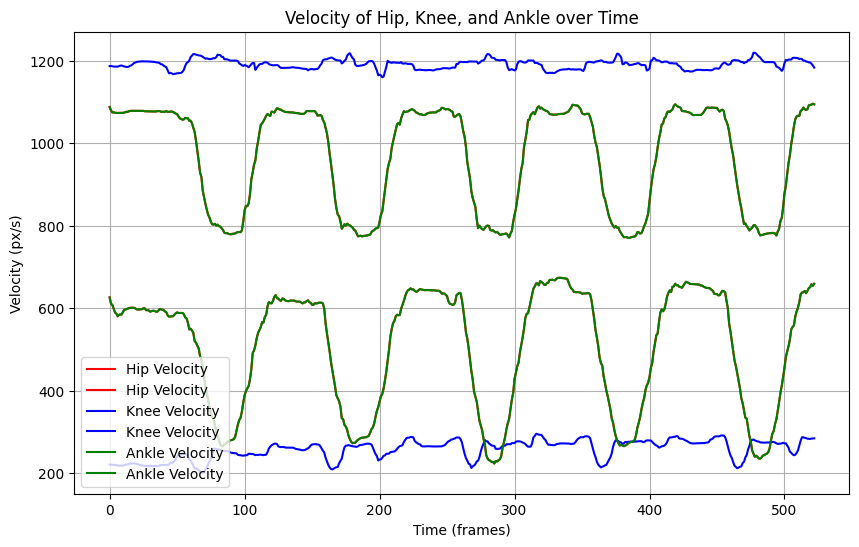

In [102]:
import matplotlib.pyplot as plt

time_steps = list(range(len(hip_velocity_history)))  # Generate time steps equal to the number of velocity measurements

# Plotting the velocities
plt.figure(figsize=(10, 6))
plt.plot(time_steps, hip_velocity_history, label='Hip Velocity', color='red')
plt.plot(time_steps, knee_velocity_history, label='Knee Velocity', color='blue')
plt.plot(time_steps, ankle_velocity_history, label='Ankle Velocity', color='green')
plt.xlabel('Time (frames)')
plt.ylabel('Velocity (px/s)')
plt.title('Velocity of Hip, Knee, and Ankle over Time')
plt.legend()
plt.grid(True)
plt.show()


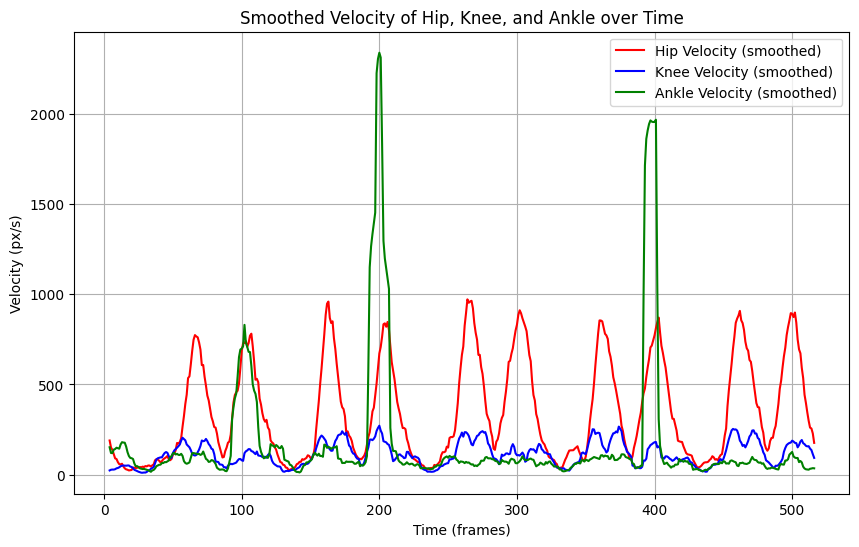

In [34]:
# 1. Velocity Smoothness Graphs
# Plotting the moving average or applying a low-pass filter to the velocity data can help in visualizing the smoothness by reducing the noise and highlighting the general trend of the movement.

# Example Plot - Moving Average of Velocity:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Example data
time_steps = np.arange(len(hip_velocity_history))

# Calculate moving averages
hip_ma = moving_average(hip_velocity_history, window_size=10)
knee_ma = moving_average(knee_velocity_history, window_size=10)
ankle_ma = moving_average(ankle_velocity_history, window_size=10)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps[4:-5], hip_ma, label='Hip Velocity (smoothed)', color='red')
plt.plot(time_steps[4:-5], knee_ma, label='Knee Velocity (smoothed)', color='blue')
plt.plot(time_steps[4:-5], ankle_ma, label='Ankle Velocity (smoothed)', color='green')
plt.xlabel('Time (frames)')
plt.ylabel('Velocity (px/s)')
plt.title('Smoothed Velocity of Hip, Knee, and Ankle over Time')
plt.legend()
plt.grid(True)
plt.show()


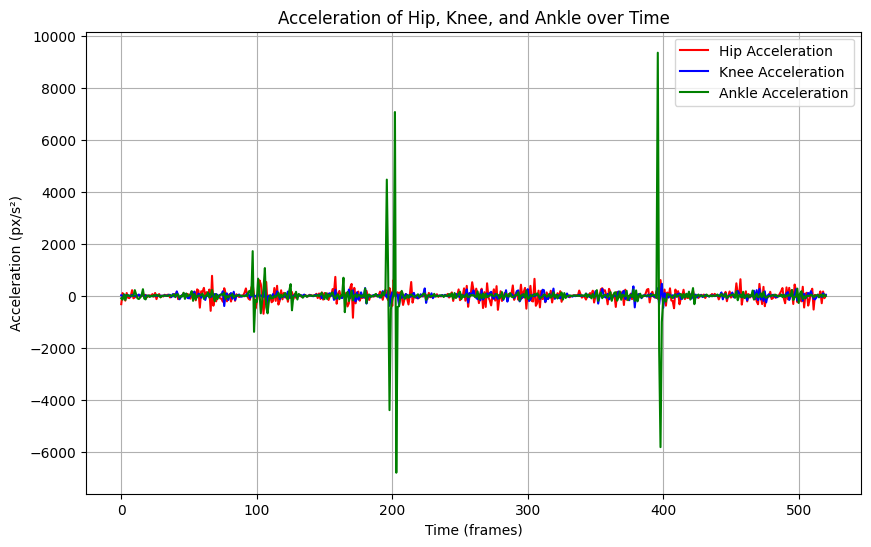

In [35]:
# 2. Acceleration Graphs
# Acceleration can be calculated as the derivative of velocity. By plotting acceleration, you can assess how abrupt or smooth the changes in velocity are, which reflects on the motion's smoothness.

# Example Plot - Acceleration:
# Calculate acceleration as the difference of velocity
hip_acceleration = np.diff(hip_velocity_history, n=1)
knee_acceleration = np.diff(knee_velocity_history, n=1)
ankle_acceleration = np.diff(ankle_velocity_history, n=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps[:-1], hip_acceleration, label='Hip Acceleration', color='red')
plt.plot(time_steps[:-1], knee_acceleration, label='Knee Acceleration', color='blue')
plt.plot(time_steps[:-1], ankle_acceleration, label='Ankle Acceleration', color='green')
plt.xlabel('Time (frames)')
plt.ylabel('Acceleration (px/s²)')
plt.title('Acceleration of Hip, Knee, and Ankle over Time')
plt.legend()
plt.grid(True)
plt.show()


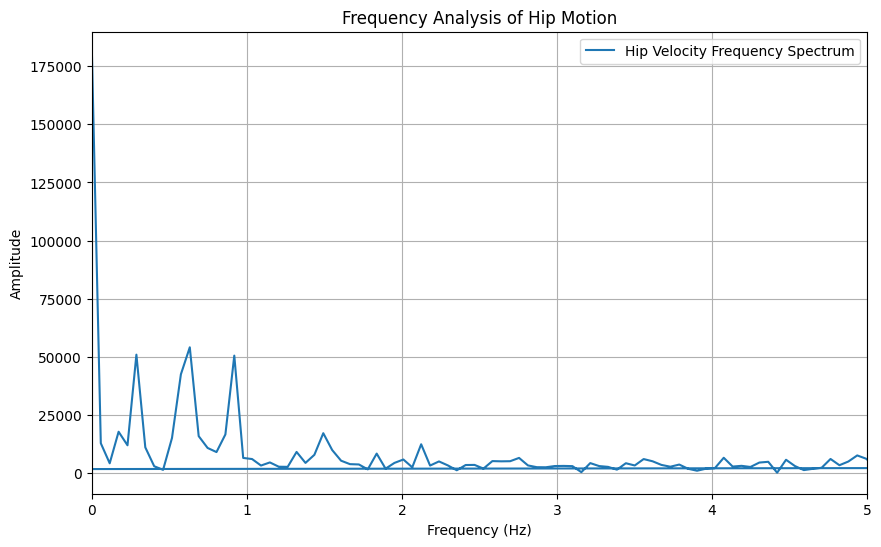

: 

In [36]:
# 4. Frequency Analysis
# Performing a Fourier Transform to analyze the frequency components of the motion can also help in identifying the smoothness. Smooth motions typically have fewer high-frequency components.

# Example of Frequency Analysis Plot:
from scipy.fft import fft, fftfreq

# Calculate FFT
hip_fft = fft(hip_velocity_history)
frequencies = fftfreq(len(hip_velocity_history), d=frame_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(hip_fft), label='Hip Velocity Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Analysis of Hip Motion')
plt.xlim([0, 5])  # Limiting to relevant frequencies
plt.legend()
plt.grid(True)
plt.show()
